# Introduction


This project demonstrates how to fine-tune a pre-trained BERT model (bert-base-uncased) for binary text classification — identifying whether a tweet is toxic or non-toxic.

We use PyTorch and Hugging Face Transformers to build and train a deep learning model for text classification.

**Key Highlights**

**Dataset:** Real-world tweets labeled as toxic or non-toxic, sourced from Kaggle.

**Data Split:** We apply stratified train/validation/test splits to maintain label balance.

**Model:** Fine-tune BERT (bert-base-uncased) end-to-end on the dataset.

**Regularization:** Incorporate dropout and learning rate scheduling to prevent overfitting.

**Performance:** Achieves ~95% accuracy on the test set.

**Evaluation:** Includes confusion matrix and real-time custom input predictions to demonstrate model capability.

# Installing & Importing Libraries

In [ ]:
!pip install transformers==4.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 64.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.17.6 requires transformers>=4.33.1, but you have transformers 4.28.1 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.1 which 

In [ ]:

# Hugging Face Transformers (for BERT and tokenization)
import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)

# Core PyTorch libraries
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Data handling and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Utilities
from collections import defaultdict
from textwrap import wrap

# ----------------------------- #
# Notebook Settings for Visualization
# ----------------------------- #
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set seaborn styling and custom color palette
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE", "#FFDD00", "#FF7D00",
    "#FF006D", "#ADFF02", "#8F00FF"
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# ----------------------------- #
# Set Random Seed for Reproducibility
# ----------------------------- #
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ----------------------------- #
# Select Device (GPU if available)
# ----------------------------- #
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


2025-07-19 11:36:09.489341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752924969.669586      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752924969.721046      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda:0


# Importing and Exploring Dataset.

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/toxictweets/FinalBalancedDataset.csv')
df.head()


,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [ ]:
df.shape

(56745, 3)

In [ ]:
# Dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56745 non-null  int64 
 1   Toxicity    56745 non-null  int64 
 2   tweet       56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


In [ ]:
df = df.rename(columns={'tweet': 'text', 'Toxicity': 'label'})


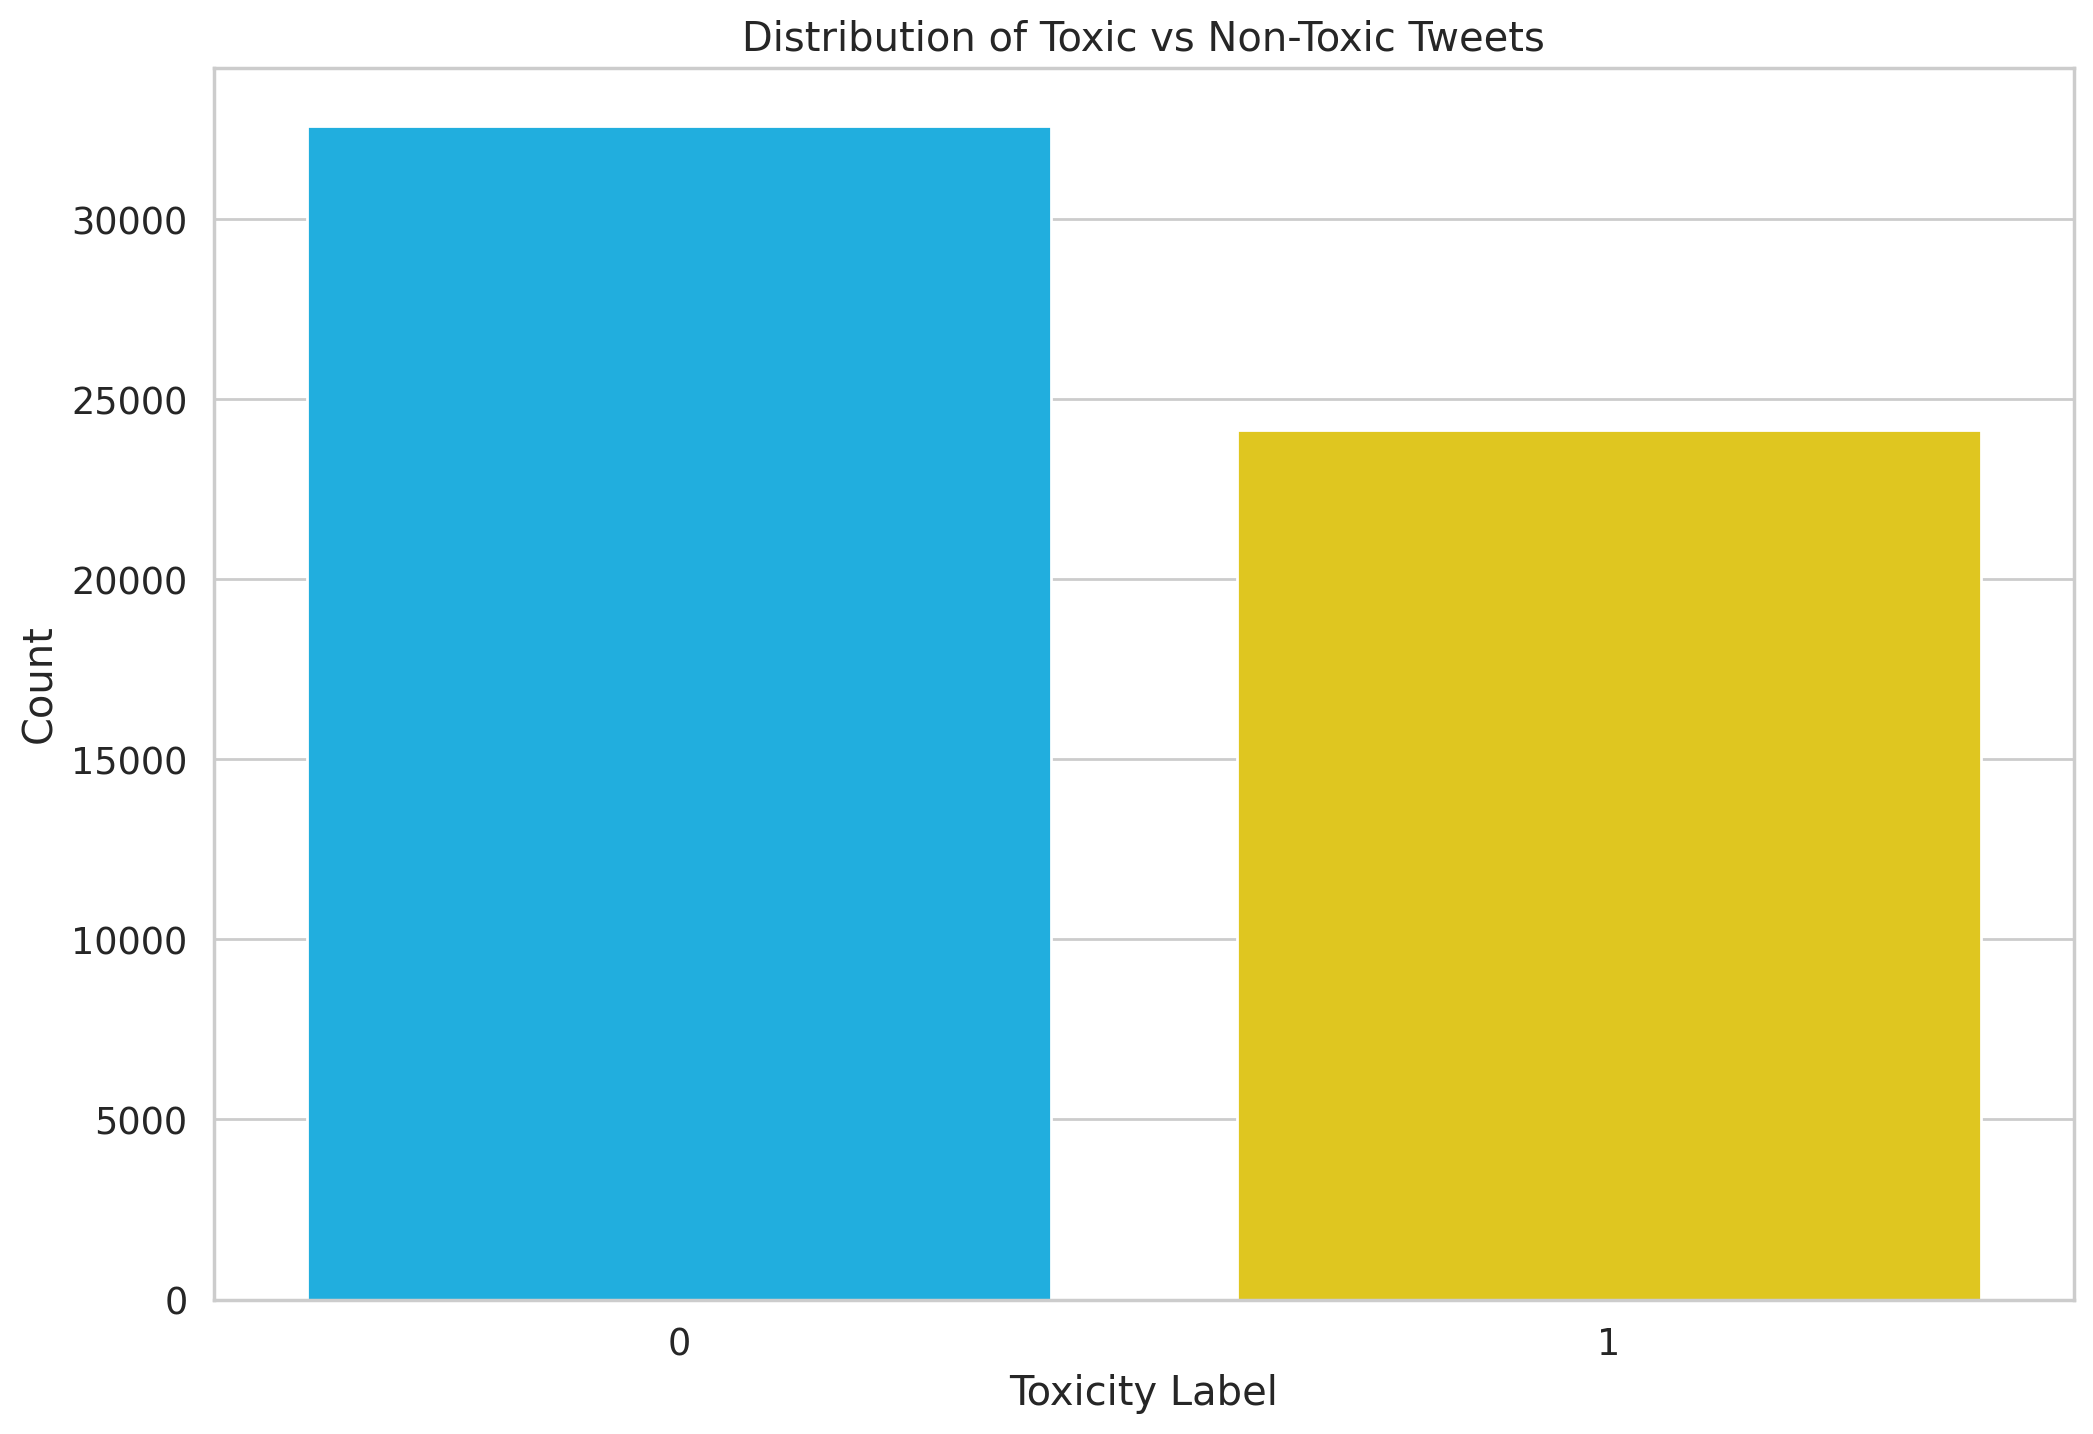

In [ ]:
# Plot distribution of toxic vs. non-toxic tweets
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
sns.countplot(data=df, x='label')
plt.xlabel('Toxicity Label')
plt.ylabel('Count')
plt.title('Distribution of Toxic vs Non-Toxic Tweets')
plt.show()


# Data Preprocessing.

In [ ]:
df['sentiment'] = df['label'].apply(lambda x: 'non toxic' if x == 0 else 'toxic')


In [ ]:
# Use pre-trained BERT model (case-sensitive)
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'


In [ ]:
from transformers import AutoTokenizer

# Load BERT tokenizer using AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
sample_txt = "@user stop being annoying. nobody asked you."


In [ ]:
# Tokenize the sample sentence and convert tokens to IDs
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Display original sentence, tokens, and token IDs
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')


 Sentence: @user stop being annoying. nobody asked you.
   Tokens: ['@', 'user', 'stop', 'being', 'annoying', '.', 'nobody', 'asked', 'you', '.']
Token IDs: [137, 4795, 1831, 1217, 17090, 119, 8582, 1455, 1128, 119]


In [ ]:
# Special tokens used by BERT and their IDs
print(f"SEP token: {tokenizer.sep_token} — ID: {tokenizer.sep_token_id}")
print(f"CLS token: {tokenizer.cls_token} — ID: {tokenizer.cls_token_id}")
print(f"PAD token: {tokenizer.pad_token} — ID: {tokenizer.pad_token_id}")
print(f"UNK token: {tokenizer.unk_token} — ID: {tokenizer.unk_token_id}")


SEP token: [SEP] — ID: 102
CLS token: [CLS] — ID: 101
PAD token: [PAD] — ID: 0
UNK token: [UNK] — ID: 100


In [ ]:
# Encode the sample sentence using BERT tokenizer
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,      # Add [CLS] and [SEP]
    return_token_type_ids=False,  # Not needed for single sentence tasks
    padding='max_length',         # Pad to fixed length
    truncation=True,              # Truncate if longer than max_length
    return_attention_mask=True,   # Generate attention mask
    return_tensors='pt'           # Return PyTorch tensors
)

# Display the keys returned in the encoding dictionary
print(encoding.keys())


dict_keys(['input_ids', 'attention_mask'])


In [ ]:
# Check length of input IDs (should match max_length)
print(len(encoding['input_ids'][0]))

# View the actual input IDs tensor
encoding['input_ids'][0]


32


tensor([  101,   137,  4795,  1831,  1217, 17090,   119,  8582,  1455,  1128,
          119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
# Check length of attention mask (should also match max_length)
print(len(encoding['attention_mask'][0]))

# View the attention mask tensor
encoding['attention_mask']


32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Calculate token lengths for all tweets
token_lens = []
for txt in df['text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


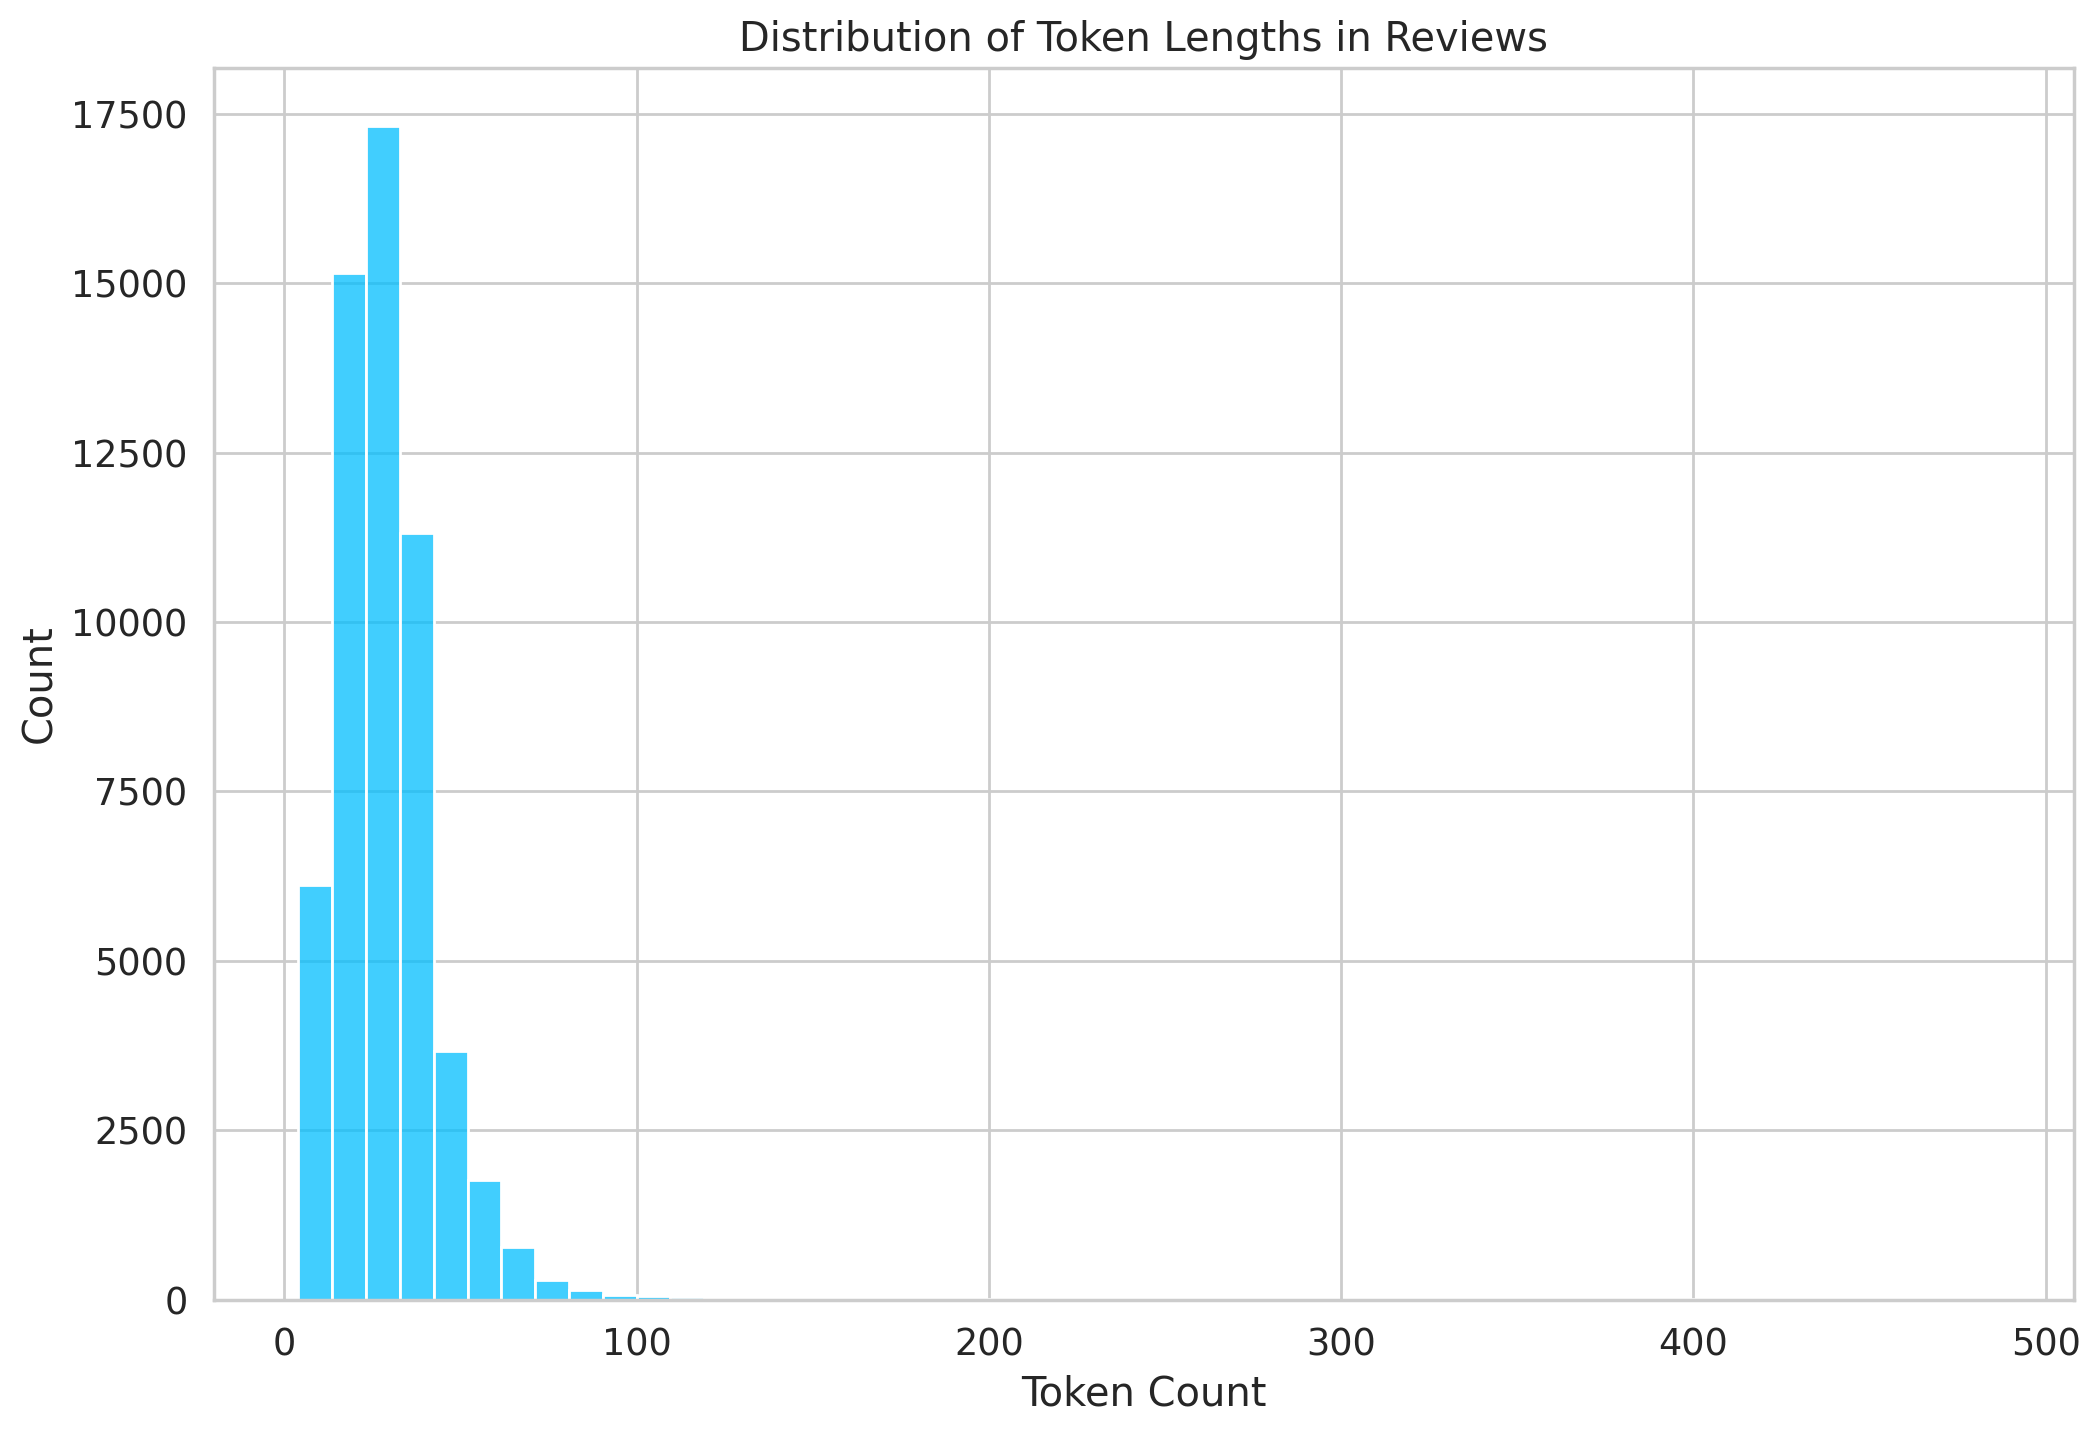

In [ ]:
# Plot distribution of token lengths
sns.histplot(token_lens, bins=50)
plt.xlabel('Token Count')
plt.title('Distribution of Token Lengths in Reviews')
plt.show()


In [ ]:
# Set maximum token length for BERT input
# Most reviews had fewer than 80 tokens, so 80 is a safe upper bound
MAX_LEN = 80


In [ ]:
# Custom Dataset class for toxic tweet classification
class ToxicTweetDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets              # Series of tweet texts
        self.targets = targets            # Corresponding sentiment labels (0 or 1)
        self.tokenizer = tokenizer        # BERT tokenizer
        self.max_len = max_len            # Max token length (e.g., 100)

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [ ]:
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp (val + test)
df_train, df_temp = train_test_split(
    df,
    test_size=0.2,
    stratify=df['sentiment'],
    random_state=42
)

# Second split: 10% val, 10% test from the 20% temp
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp['sentiment'],
    random_state=42
)

# Check shape
print("Train size:", df_train.shape)
print("Validation size:", df_val.shape)
print("Test size:", df_test.shape)


Train size: (45396, 4)
Validation size: (5674, 4)
Test size: (5675, 4)


In [ ]:
# Check original distribution
print("Original distribution:")
print(df['sentiment'].value_counts(normalize=True))

# Check distribution in train set
print("\nTrain set distribution:")
print(df_train['sentiment'].value_counts(normalize=True))

# Check distribution in validation set
print("\nValidation set distribution:")
print(df_val['sentiment'].value_counts(normalize=True))

# Check distribution in test set
print("\nTest set distribution:")
print(df_test['sentiment'].value_counts(normalize=True))


Original distribution:
sentiment
non toxic    0.574359
toxic        0.425641
Name: proportion, dtype: float64

Train set distribution:
sentiment
non toxic    0.574368
toxic        0.425632
Name: proportion, dtype: float64

Validation set distribution:
sentiment
non toxic    0.574374
toxic        0.425626
Name: proportion, dtype: float64

Test set distribution:
sentiment
non toxic    0.574273
toxic        0.425727
Name: proportion, dtype: float64


In [ ]:
# Function to create a DataLoader from a DataFrame
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ToxicTweetDataset(
        tweets=df["text"].to_numpy(),
        targets=df["label"].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

# Set batch size
BATCH_SIZE = 8

# Create DataLoaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader   = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader  = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
# Get one batch from the training DataLoader
data = next(iter(train_data_loader))

# Print keys in batch dictionary
print(data.keys())

# Print shapes of tensors in batch
print(data['input_ids'].shape)        # Expected: [BATCH_SIZE, MAX_LEN]
print(data['attention_mask'].shape)   # Expected: [BATCH_SIZE, MAX_LEN]
print(data['targets'].shape)          # Expected: [BATCH_SIZE]


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 80])
torch.Size([8, 80])
torch.Size([8])


# Model Definition & Training Setup

In [ ]:
# Load pre-trained BERT base model (cased)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)


In [ ]:
class_names = ['non toxic', 'toxic']
model = SentimentClassifier(n_classes=len(class_names))
model = model.to(device)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Get one batch of data from the training DataLoader
data = next(iter(train_data_loader))

# Move input IDs and attention masks tensors to the selected device (GPU or CPU)
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)


In [ ]:
import torch.nn.functional as F

# Disable gradient computation — inference mode
with torch.no_grad():
    # Forward pass through the model to get logits
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Convert logits to probabilities using softmax
    probs = F.softmax(outputs, dim=1)

    # Get predicted class indices
    preds = torch.argmax(probs, dim=1)

    # Print output shapes and values
    print("Output logits shape:", outputs.shape)      # [batch_size, num_classes]
    print("Predicted probabilities:", probs)
    print("Predicted classes:", preds)


Output logits shape: torch.Size([8, 2])
Predicted probabilities: tensor([[0.3410, 0.6590],
        [0.4658, 0.5342],
        [0.6183, 0.3817],
        [0.3359, 0.6641],
        [0.6805, 0.3195],
        [0.4367, 0.5633],
        [0.4522, 0.5478],
        [0.5844, 0.4156]], device='cuda:0')
Predicted classes: tensor([1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

EPOCHS = 10
LEARNING_RATE = 2e-5

# ⚙️ Optimizer setup
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01, correct_bias=False)

# 🔢 Total training steps for the scheduler
total_steps = len(train_data_loader) * EPOCHS

# 🔁 Learning rate scheduler with warmup (10% of total steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# 🎯 Loss function
loss_fn = nn.CrossEntropyLoss().to(device)


# Model Training & Evaluation

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()  # Set model to training mode
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)  # Predicted class

        loss = loss_fn(outputs, targets)  # Compute loss
        correct_predictions += torch.sum(preds == targets)  # Count correct predictions
        losses.append(loss.item())

        loss.backward()  # Backpropagation
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradients
        optimizer.step()  # Update weights
        scheduler.step()  # Update learning rate scheduler
        optimizer.zero_grad()  # Reset gradients

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)
    losses = []
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient calculation
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs, dim=1)  # Get predicted classes
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
%%time

from collections import defaultdict
import copy  # Needed to save best model weights

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Training step
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}')

    # Validation step
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}\n')

    # Save metrics
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save best model based on validation accuracy
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model_state.bin')


Epoch 1/10
----------
Train loss: 0.2478 | Accuracy: 0.9209
Val   loss: 0.1879 | Accuracy: 0.9491

Epoch 2/10
----------
Train loss: 0.1534 | Accuracy: 0.9598
Val   loss: 0.1909 | Accuracy: 0.9584

Epoch 3/10
----------
Train loss: 0.0976 | Accuracy: 0.9770
Val   loss: 0.2462 | Accuracy: 0.9573

Epoch 4/10
----------
Train loss: 0.0537 | Accuracy: 0.9892
Val   loss: 0.3060 | Accuracy: 0.9554

Epoch 5/10
----------
Train loss: 0.0288 | Accuracy: 0.9946
Val   loss: 0.3232 | Accuracy: 0.9554

Epoch 6/10
----------
Train loss: 0.0174 | Accuracy: 0.9970
Val   loss: 0.3447 | Accuracy: 0.9577

Epoch 7/10
----------
Train loss: 0.0104 | Accuracy: 0.9982
Val   loss: 0.3479 | Accuracy: 0.9593

Epoch 8/10
----------
Train loss: 0.0052 | Accuracy: 0.9991
Val   loss: 0.4085 | Accuracy: 0.9581

Epoch 9/10
----------
Train loss: 0.0030 | Accuracy: 0.9995
Val   loss: 0.4288 | Accuracy: 0.9582

Epoch 10/10
----------
Train loss: 0.0022 | Accuracy: 0.9997
Val   loss: 0.4325 | Accuracy: 0.9572

CPU times

# Evaluation & Visualization

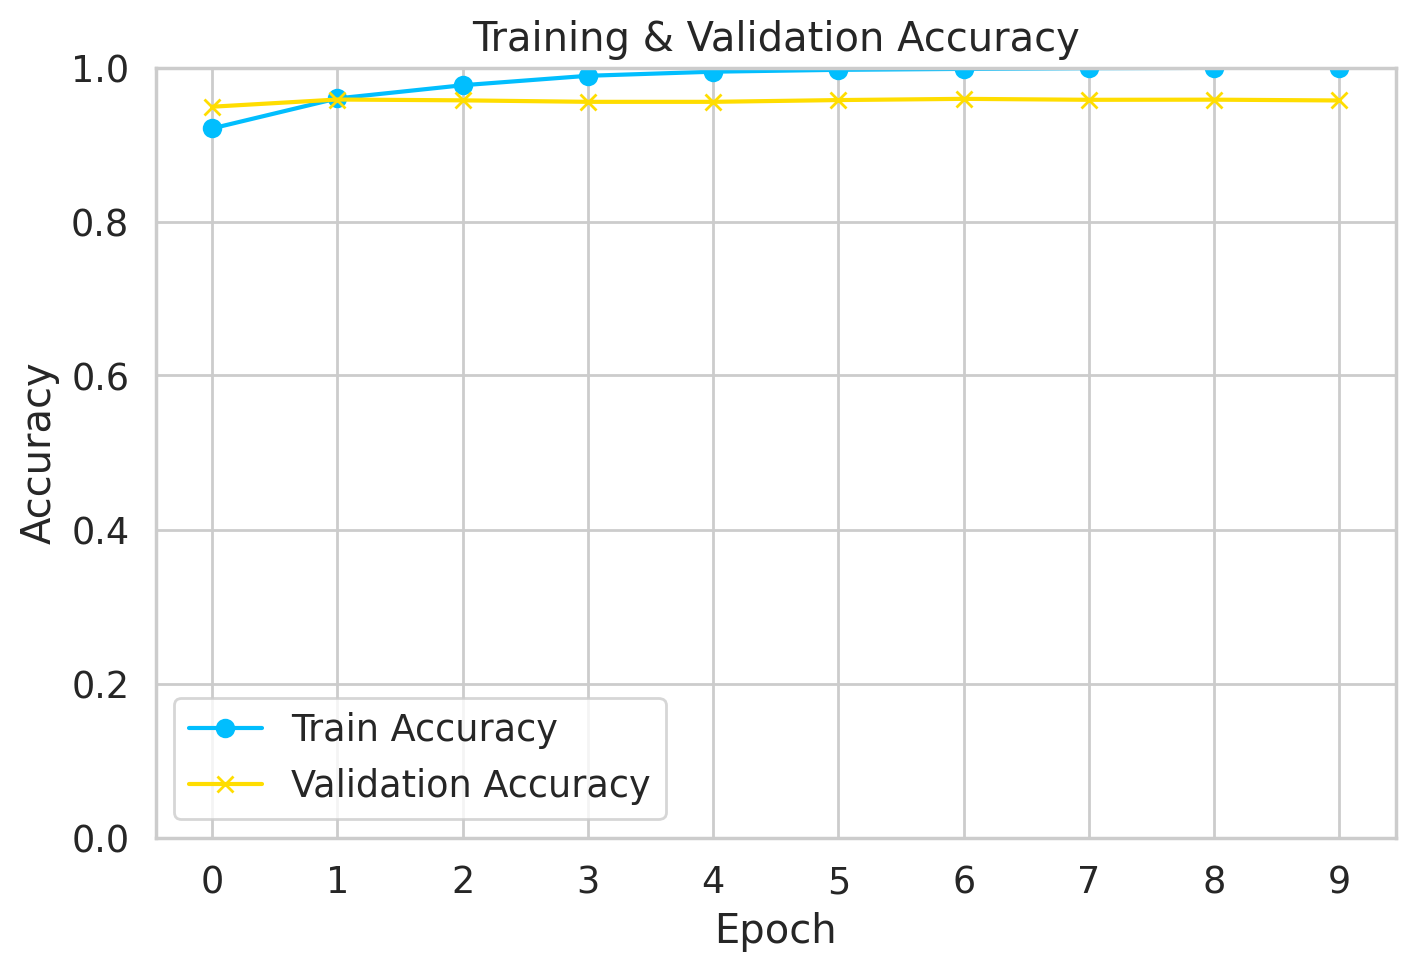

In [ ]:
import matplotlib.pyplot as plt
import torch

# Convert accuracy tensors (if on GPU) to CPU floats
train_acc = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_acc']]
val_acc = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_acc']]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='x')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])  # Accuracy range
plt.xticks(range(len(train_acc)))  # Ensure all epochs are shown
plt.show()


In [ ]:
print("Train accs:", train_acc)
print("Val accs:", val_acc)


Train accs: [0.9208520574499955, 0.9598422768525862, 0.976958322319147, 0.989228125826064, 0.9945589919816724, 0.9969821129614944, 0.9981936734514054, 0.9990748083531589, 0.9995153758040356, 0.9996695744118425]
Val accs: [0.9490659146986253, 0.9584067677123722, 0.9573493126542122, 0.9554106450475854, 0.9554106450475854, 0.9577017976735989, 0.959287980260839, 0.9580542826929855, 0.9582305252026788, 0.9571730701445188]


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.9548898678414097

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# Run model on test data to get predictions and related info
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


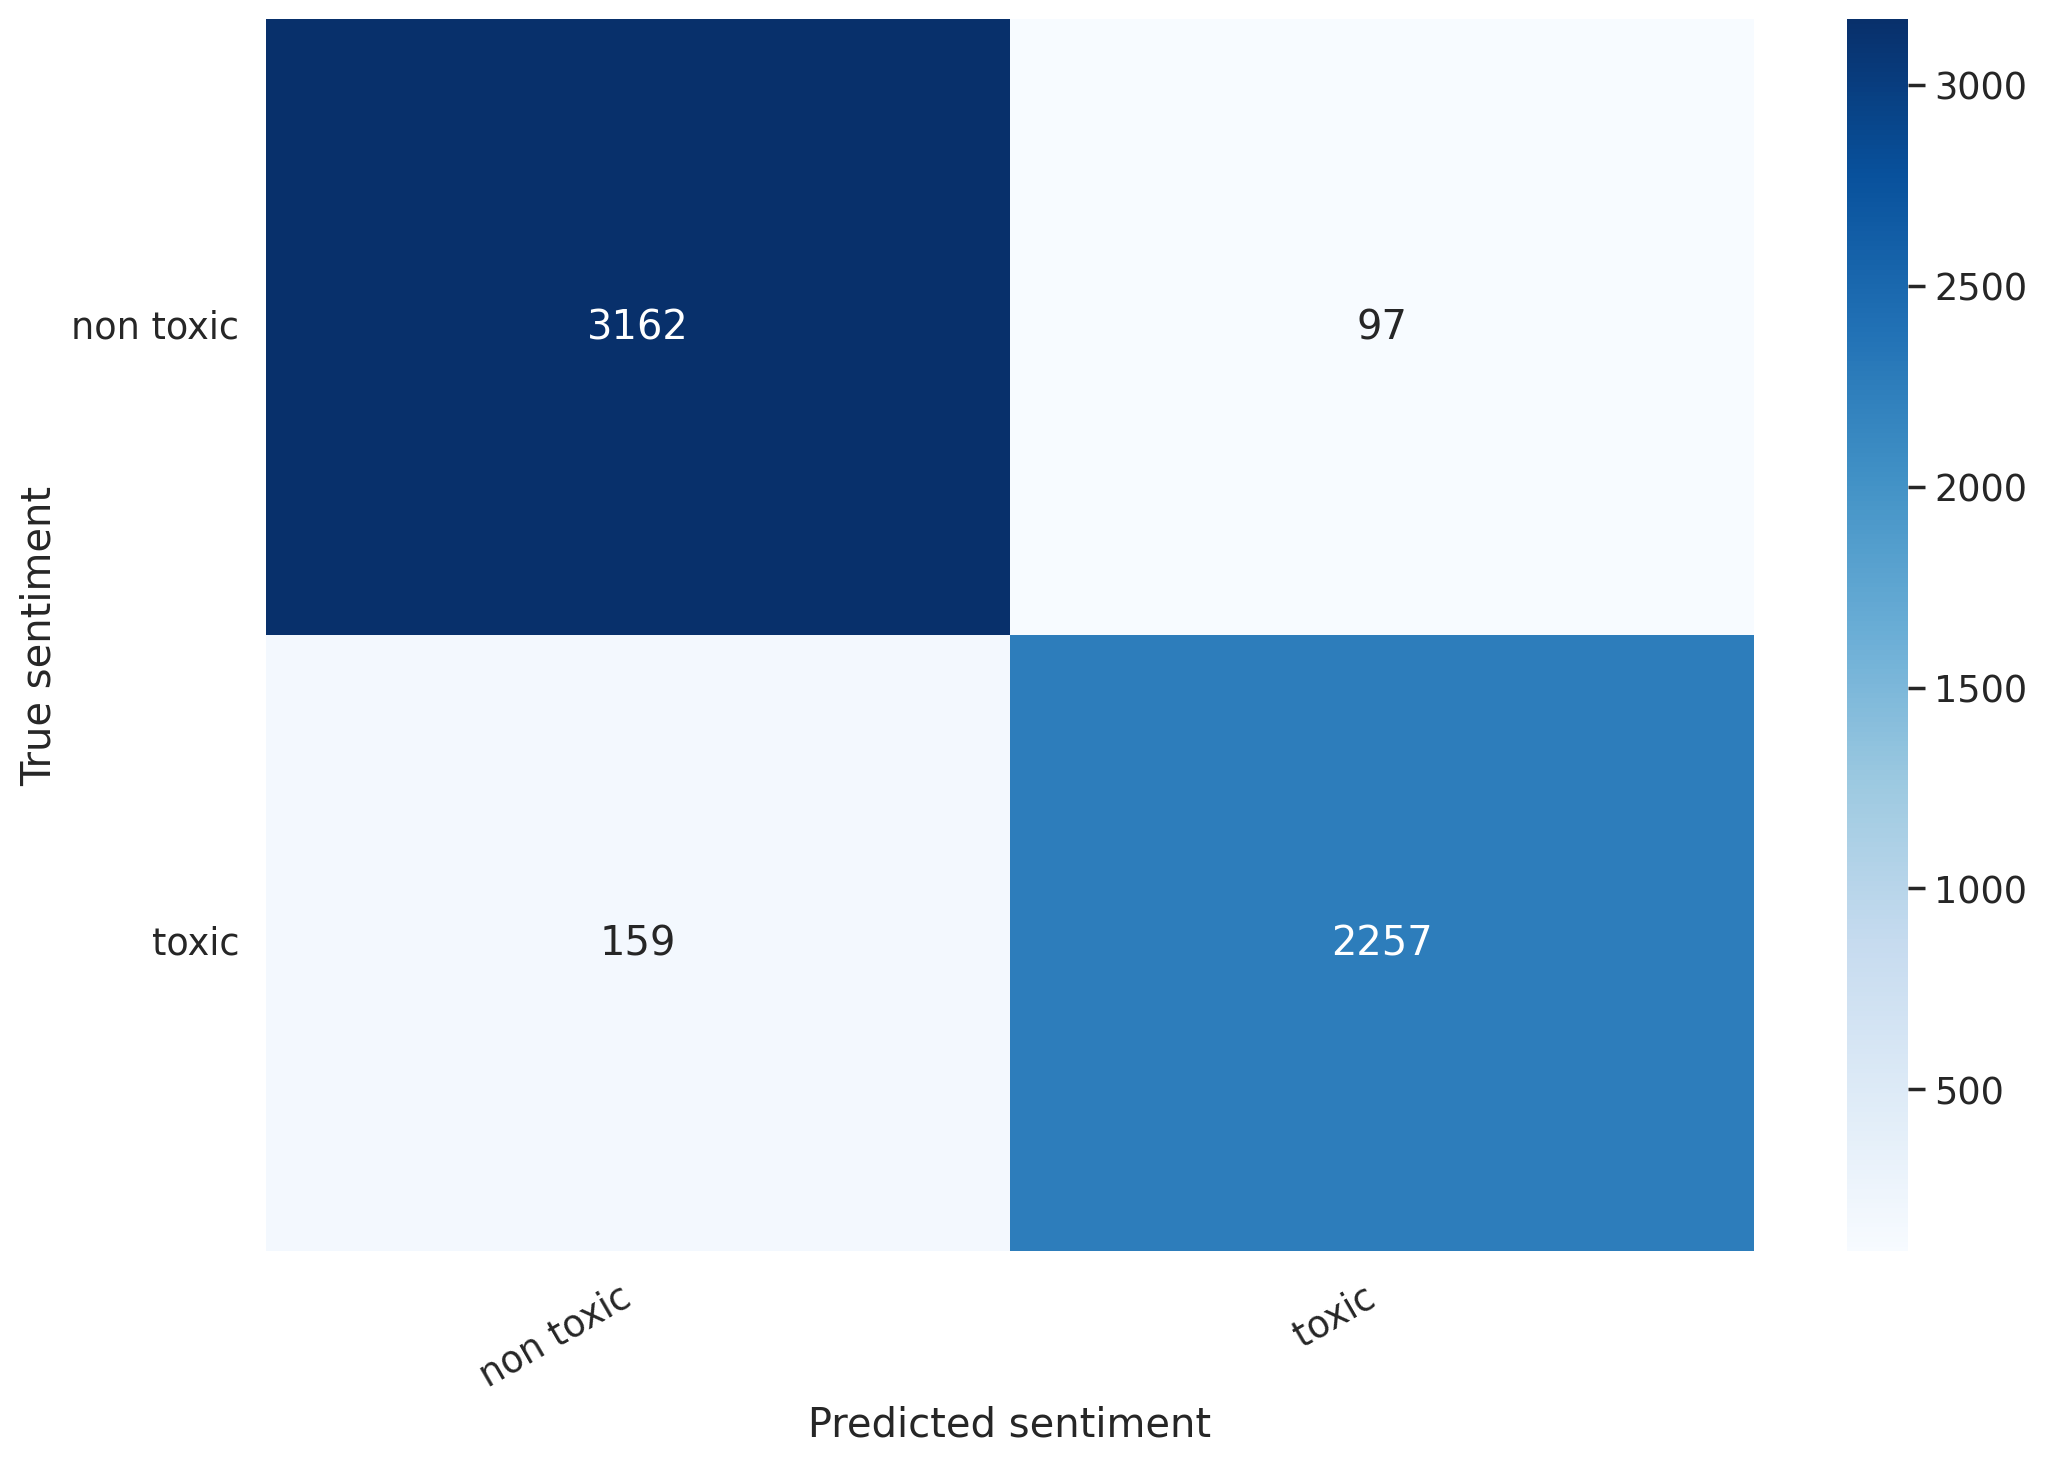

In [ ]:
# Function to display the confusion matrix as a heatmap
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

# Generate and format confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# Show confusion matrix
show_confusion_matrix(df_cm)


# Test Set Sample Predictions

In [ ]:
idx = 2
review_text = y_review_texts[idx]
true_label = y_test[idx]
predicted_label = y_pred[idx]

pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})

print(f"REVIEW:\n{review_text}\n")
print(f"True Label     : {class_names[true_label]}")
print(f"Predicted Label: {class_names[predicted_label]}\n")



REVIEW:
Thinking bout gettin 500$ put on my ears cuz I'm getting money bitch

True Label     : toxic
Predicted Label: toxic



# Raw Data Prediction

In [ ]:
review_text = "You're such a worthless idiot. No one wants to hear your garbage."


In [ ]:
# Encode raw review text into BERT input format
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt'
)


In [ ]:
import torch.nn.functional as F

# Move inputs to the device
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

# Get model output
output = model(input_ids, attention_mask)

# Apply softmax to convert logits to probabilities
probs = F.softmax(output, dim=1)

# Get predicted class
_, prediction = torch.max(probs, dim=1)

# Display review, predicted sentiment, and probabilities
print(f"Review text     : {review_text}")
print(f"Predicted label : {class_names[prediction]}")
print(f"Class probabilities:")
for i, prob in enumerate(probs[0]):
    print(f"  {class_names[i]}: {prob.item():.4f}")


Review text     : You're such a worthless idiot. No one wants to hear your garbage.
Predicted label : toxic
Class probabilities:
  non toxic: 0.0000
  toxic: 1.0000
